## Data Load ##

In [1]:
import pandas as pd
import numpy as np
import sqlite3

In [2]:
df_customer = pd.read_csv('customer.csv')
df_items = pd.read_csv('items.csv')
df_orders = pd.read_csv('orders.csv')
df_products = pd.read_csv('products.csv')

print('customer')
display(df_customer.tail(1))
print('items')
display(df_items.tail(1))
print('orders')
display(df_orders.tail(1))
print('products')
display(df_products.tail(1))

customer


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
99442,274fa6071e5e17fe303b9748641082c8,84732c5050c01db9b23e19ba39899398,6703.0,cotia,SP


items


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
112649,fffe41c64501cc87c801fd61db3f6244,1,350688d9dc1e75ff97be326363655e01,f7ccf836d21b2fb1de37564105216cc1,2018-06-12 17:10:13,43.0,12.79


orders


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
99440,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00


products


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
32951,106392145fca363410d287a815be6de4,bed_bath_table,58.0,309.0,1.0,2083.0,12.0,2.0,7.0,bed_bath_table


In [11]:
conn = sqlite3.connect('e_commerce.db')
c = conn.cursor()

c.execute(f"CREATE TABLE IF NOT EXISTS specialities ({', '.join(df_customer.columns)})")
conn.commit()
df_customer.to_sql('customer', conn, if_exists='replace', index = False)

c.execute(f"CREATE TABLE IF NOT EXISTS physicians ({', '.join(df_items.columns)})")
conn.commit()
df_items.to_sql('items', conn, if_exists='replace', index = False)

c.execute(f"CREATE TABLE IF NOT EXISTS consultations ({', '.join(df_orders.columns)})")
conn.commit()
df_orders.to_sql('orders', conn, if_exists='replace', index = False)

c.execute(f"CREATE TABLE IF NOT EXISTS patients ({', '.join(df_products.columns)})")
conn.commit()
df_products.to_sql('products', conn, if_exists='replace', index = False)

32952

## Data Analysis ##

In [124]:
con = sqlite3.connect('e_commerce.db')

 **Sales:**

 1. What is the average basket by product category

In [97]:
avg_basket = pd.read_sql(
    '''
        SELECT 
            p.product_category_name_english,
            AVG(i.price) AS avg_basket
        FROM 
            items i
        LEFT JOIN 
            products p ON i.product_id = p.product_id
        GROUP BY
            p.product_category_name_english
        ORDER BY 
            avg_basket DESC 

    ''', 
    con
)

avg_basket.to_sql('Sales-1-avg_basket', con, if_exists='replace', index=False)

72

 2. What are the most popular products?

According to order

In [98]:
# product category

most_popular_category_by_order = pd.read_sql(
    '''
        SELECT 
            p.product_category_name_english,
            COUNT(i.order_id) AS count_order
        FROM 
            items i
        LEFT JOIN 
            products p ON i.product_id = p.product_id
        GROUP BY
            p.product_category_name_english
        ORDER BY 
            count_order DESC 
        LIMIT 15

    ''', 
    con
)

most_popular_category_by_order.to_sql('Sales-2-most_popular_category_by_order', con, if_exists='replace', index=False)

15

In [99]:
# product

most_popular_products_by_order = pd.read_sql(
    '''
        SELECT 
            p.product_category_name_english,
            p.product_id,
            COUNT(order_id) AS count_order
        FROM 
            items i
        LEFT JOIN 
            products p ON i.product_id = p.product_id
        GROUP BY
            p.product_id
        ORDER BY 
            count_order DESC 
        LIMIT 15

    ''', 
    con
)

most_popular_products_by_order.to_sql('Sales-2-most_popular_products_by_order', con, if_exists='replace', index=False)

15

According to price

In [100]:
# product category

most_popular_category_by_price = pd.read_sql(
    '''
        SELECT 
            p.product_category_name_english,
            SUM(i.price) AS sum_price
        FROM 
            items i
        LEFT JOIN 
            products p ON i.product_id = p.product_id
        GROUP BY
            p.product_category_name_english
        ORDER BY 
            sum_price DESC 
        LIMIT 15

    ''', 
    con
)

most_popular_category_by_price.to_sql('Sales-2-most_popular_category_by_price', con, if_exists='replace', index=False)

15

In [101]:
# product

most_popular_products_by_price = pd.read_sql(
    '''
        SELECT 
            p.product_category_name_english,
            p.product_id,
            SUM(price) AS sum_price
        FROM 
            items i
        LEFT JOIN 
            products p ON i.product_id = p.product_id
        GROUP BY
            p.product_id
        ORDER BY 
            sum_price DESC 
        LIMIT 15

    ''', 
    con
)

most_popular_products_by_price.to_sql('Sales-2-most_popular_products_by_price', con, if_exists='replace', index=False)

15

 3. What are repeat customers mostly buying 

In [33]:
# unique test

order_id_unique = df_orders['order_id'].is_unique
print(order_id_unique)
customer_id_unique = df_orders['customer_id'].is_unique
print(customer_id_unique)

True
True


In [102]:
# Selecet customers who have ordered more than once
# Based on the selected customers, calculate the product categories they purchased most

query="""

WITH repeat_customer AS (
SELECT
    customer_id
FROM
    customer
WHERE
    customer_unique_id IN (
    SELECT
        customer_unique_id
    FROM
        customer
    GROUP BY 
        customer_unique_id
    HAVING 
        COUNT(DISTINCT customer_id) > 1)
)


SELECT 
    p.product_category_name_english,
    COUNT(i.order_id) AS count_repeat_category
FROM
    orders o
INNER JOIN
    repeat_customer rc ON o.customer_id = rc.customer_id
LEFT JOIN
    items i ON o.order_id = i.order_id
LEFT JOIN
    products p ON i.product_id = p.product_id
GROUP BY
    p.product_category_name_english
ORDER BY
    count_repeat_category DESC
    
"""

categories_repeater_mostly_buying = pd.read_sql_query(sql=query, con=con)
categories_repeater_mostly_buying.to_sql('Sales-3-categories_repeater_mostly_buying', con, if_exists='replace', index=False)

69

In [103]:
# Selecet customers who have ordered more than once
# Based on the selected customers, calculate the products they purchased most

query="""

WITH repeat_customer AS (
SELECT
    customer_id
FROM
    customer
WHERE
    customer_unique_id IN (
    SELECT
        customer_unique_id
    FROM
        customer
    GROUP BY 
        customer_unique_id
    HAVING 
        COUNT(DISTINCT customer_id) > 1)
)


SELECT 
    p.product_category_name_english,
    p.product_id,
    COUNT(i.order_id) AS count_repeat_product
FROM
    orders o
INNER JOIN
    repeat_customer rc ON o.customer_id = rc.customer_id
LEFT JOIN
    items i ON o.order_id = i.order_id
LEFT JOIN
    products p ON i.product_id = p.product_id
GROUP BY
    p.product_id
ORDER BY
    count_repeat_product DESC
    
"""

products_repeater_mostly_buying = pd.read_sql_query(sql=query, con=con)
products_repeater_mostly_buying.to_sql('Sales-3-products_repeater_mostly_buying', con, if_exists='replace', index=False)

4649

 4. How many customers are repeaters ?

In [50]:
# unique test

customer_id = df_customer['customer_id'].is_unique
print(customer_id)
customer_unique_id = df_customer['customer_unique_id'].is_unique
print(customer_unique_id)

False
False


In [68]:
df_repeat = df_customer[df_customer['customer_unique_id'].duplicated(keep=False)]
display(df_repeat)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254.0,jaragua do sul,SC
8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560.0,curitiba,PR
13,eabebad39a88bb6f5b52376faec28612,295c05e81917928d76245e842748184d,5704.0,sao paulo,SP
18,9b8ce803689b3562defaad4613ef426f,7f3a72e8f988c6e735ba118d54f47458,5416.0,sao paulo,SP
19,9b8ce803689b3562defaad4613ef426f,7f3a72e8f988c6e735ba118d54f47458,5416.0,NaN,SP
...,...,...,...,...,...
99326,5b46a0d983eec8c97363bea78d4a69dd,8bab3162259edfaadd1ea2e1fe7f58dc,31565.0,belo horizonte,MG
99329,c1affa46f9f3b514555259049a0307b9,12ab9334b1240d6d037f2b0102a49571,38050.0,uberaba,MG
99338,ebf46ff530343a129926adc1f831dea4,0ee57f62666561b72f2ceacad0230cbf,9530.0,sao caetano do sul,SP
99355,282fbce48e4d2077aad602dd125c9225,0ceb502fc33a2ad327b08288c5310e2e,29134.0,viana,ES


In [104]:
repeaters_number = pd.read_sql(
    '''
        SELECT 
            COUNT(*) AS repeaters_count
        FROM (
          SELECT 
              customer_unique_id
          FROM 
              customer
          GROUP BY 
              customer_unique_id
          HAVING 
              COUNT(DISTINCT customer_id) > 1
        
        ) AS nb_repeat

    ''', 
    con
)

repeaters_number.to_sql('Sales-4-repeaters_number', con, if_exists='replace', index=False)

1

 **Customer Segmentation**

RFM model

In [23]:
# cleaning data

df_customer_seg = df_customer[['customer_id', 'customer_unique_id']]
df_ordes_seg = df_orders[['order_id', 'customer_id','order_purchase_timestamp']]
df_items_seg = df_items[['order_id', 'order_item_id', 'product_id', 'price']]

In [24]:
# merge dataframes

orders_items = pd.merge(df_ordes_seg, df_items_seg, on='order_id', how='inner')
orders_items_customer = pd.merge(orders_items, df_customer_seg, on='customer_id', how='inner')

In [25]:
# clean timestamp

orders_items_customer['order_purchase_timestamp'] = pd.to_datetime(
    orders_items_customer['order_purchase_timestamp'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)


In [26]:
current_date = pd.to_datetime('2019-12-31')

In [27]:
# calculate RFM value

rfm = orders_items_customer.groupby('customer_unique_id').agg({

    # Recency: lateset purchased date
    'order_purchase_timestamp': lambda x: (current_date - x.max()).days,  

    # Frequency: order number
    'order_id': 'count',  
    # nunique

    # Monetary: total amount
    'price': 'sum'  

}).reset_index()

rfm = rfm[rfm['order_purchase_timestamp'] >= 0]

In [107]:
rfm['order_id'].max()

24

In [16]:
rfm.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary']

In [17]:
# calculate RFM score

rfm['R_score'] = pd.qcut(rfm['recency'], 4, labels=[4, 3, 2, 1])
bins = [0, 5, 10, 20, 30]
rfm['F_score'] = pd.cut(rfm['frequency'], bins=bins, labels=[1, 2, 3, 4])
rfm['M_score'] = pd.qcut(rfm['monetary'], 4, labels=[1, 2, 3, 4])

rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [19]:
# Use Kmeans to classify customers
# standardization

features = ['recency', 'frequency', 'monetary']
X = rfm[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

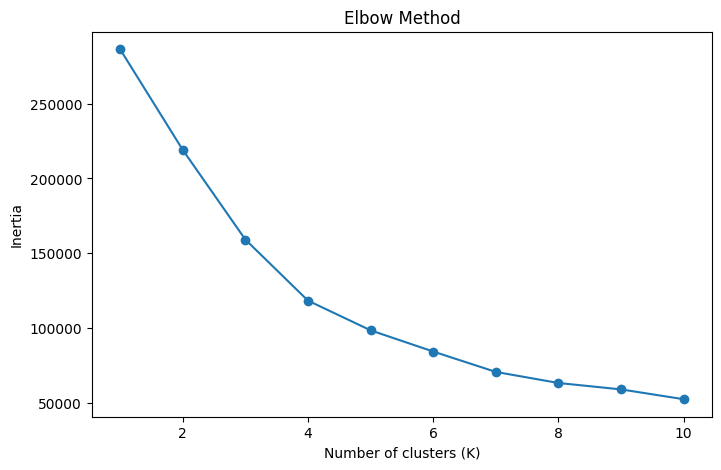

In [20]:
# calculate interia

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

d:\python\python3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Centers:
      recency  frequency     monetary
0  876.635145   1.095531   114.275745
1  725.836066   1.194379  1165.282970
2  616.532420   1.097616   113.854996
3  719.464197   3.872105   280.131938
Cluster Sizes:
Cluster
2    52146
0    38334
3     2807
1     2131
Name: count, dtype: int64


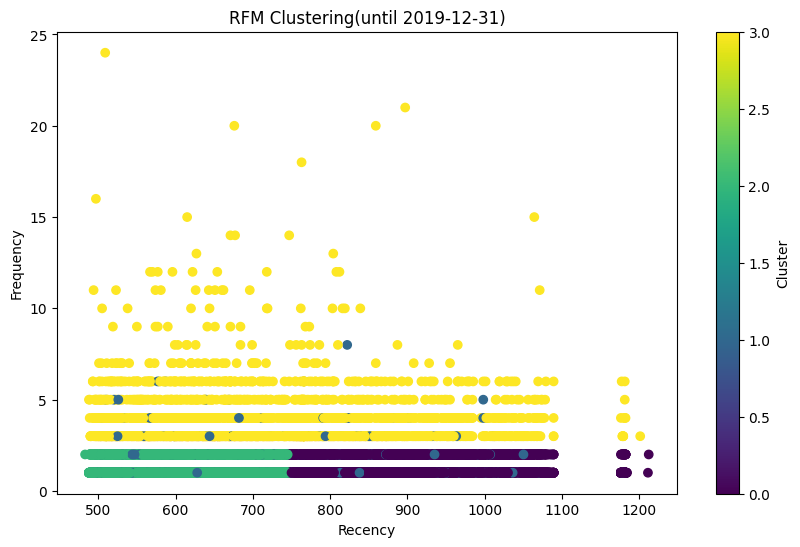

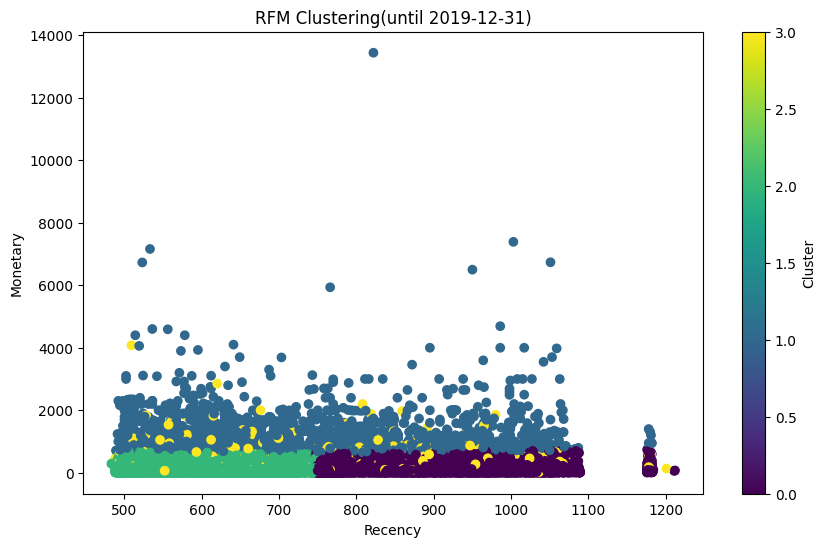

In [22]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

# clusters description

cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
print("Cluster Centers:")
print(cluster_centers)

print("Cluster Sizes:")
print(rfm['Cluster'].value_counts())


plt.figure(figsize=(10, 6))
plt.scatter(rfm['recency'], rfm['frequency'], c=rfm['Cluster'], cmap='viridis', marker='o')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('RFM Clustering(until 2019-12-31)')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(rfm['recency'], rfm['monetary'], c=rfm['Cluster'], cmap='viridis', marker='o')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('RFM Clustering(until 2019-12-31)')
plt.colorbar(label='Cluster')
plt.show()

In [93]:
rfm.to_sql('Customer Segmentation-RFM', con, index=False, if_exists='replace')

95418

 **Other Analysis**

state sales

In [17]:
# cleaning data

df_customer_state = df_customer[['customer_id', 'customer_unique_id', 'customer_state']]
df_ordes_state = df_orders[['order_id', 'customer_id']]
df_items_state = df_items[['order_id',  'price']]

In [24]:
# merge 

orders_items_state = pd.merge(df_ordes_state, df_items_state, on='order_id', how='inner')
state_sale = pd.merge(orders_items_state, df_customer_state, on='customer_id', how='inner')

In [25]:
state_sales_amount = state_sale.groupby('customer_state')['price'].sum().reset_index()
state_sales_amount.columns = ['customer_state', 'total_sales']
state_sales_amount.sort_values(by='total_sales', ascending=False).head(10)

,customer_state,total_sales
25,SP,5203084.85
18,RJ,1824092.67
10,MG,1585308.03
22,RS,750304.02
17,PR,683083.76
23,SC,520553.34
4,BA,511349.99
6,DF,302603.94
8,GO,294591.95
7,ES,275037.31


In [94]:
state_sales_amount.to_sql('Other-state_sales_amount', con, index=False, if_exists='replace')

27

state repeaters

In [26]:
state_customer = df_customer_state.groupby('customer_unique_id')['customer_id'].nunique()
state_repeat = state_customer[state_customer > 1].reset_index()
state_repeat = state_repeat.merge(df_customer_state[['customer_unique_id', 'customer_state']].drop_duplicates(), 
                                  on='customer_unique_id', 
                                  how='left')


state_repeat_amount = state_repeat.groupby('customer_state')['customer_id'].count().reset_index()
state_repeat_amount.columns = ['customer_state', 'total_repeaters']
state_repeat_amount.sort_values(by='total_repeaters', ascending=False).head(10)

,customer_state,total_repeaters
25,SP,1313
18,RJ,429
10,MG,348
22,RS,169
17,PR,149
23,SC,101
4,BA,95
8,GO,66
6,DF,65
7,ES,58


In [18]:
'''

state_customer = df_customer_state.groupby('customer_unique_id')['customer_id'].nunique()
state_repeat = state_customer[state_customer > 1].reset_index()
state_repeat = state_repeat.merge(df_customer_state.drop_duplicates(subset=['customer_unique_id'])[['customer_unique_id', 'customer_state']], 
                                  on='customer_unique_id', 
                                  how='left')

state_repeat_amount = state_repeat.groupby('customer_state')['customer_unique_id'].count().reset_index()
state_repeat_amount.columns = ['customer_state', 'total_repeaters']
state_repeat_amount.sort_values(by='total_repeaters', ascending=False).head(10)

'''

,customer_unique_id,customer_id
0,00172711b30d52eea8b313a7f2cced02,2
1,004288347e5e88a27ded2bb23747066c,2
2,004b45ec5c64187465168251cd1c9c2f,2
3,0058f300f57d7b93c477a131a59b36c3,2
4,00a39521eb40f7012db50455bf083460,2
...,...,...
2992,ff36be26206fffe1eb37afd54c70e18b,3
2993,ff44401d0d8f5b9c54a47374eb48c1b8,2
2994,ff8892f7c26aa0446da53d01b18df463,2
2995,ff922bdd6bafcdf99cb90d7f39cea5b3,3


In [95]:
state_repeat_amount.to_sql('Other-state_repeat_amount', con, index=False, if_exists='replace')

27

SP customers buying description

In [78]:
# data clean and merge

df_products_sp = df_products[['product_id',  'product_category_name_english']]
df_items_sp = df_items[['order_id', 'product_id', 'price']]
df_customer_sp = df_customer_state[df_customer_state['customer_state'] == 'SP']

orders_items_sp = pd.merge(df_ordes_state, df_items_sp, on='order_id', how='inner')
orders_items_products_sp = pd.merge(orders_items_sp, df_products_sp, on='product_id', how='inner')
sp_sale = pd.merge(orders_items_products_sp, df_customer_sp, on='customer_id', how='inner')
sp_sale

,order_id,customer_id,product_id,price,product_category_name_english,customer_unique_id,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99,housewares,7c396fd4830fd04220f754e42b4e5bff,SP
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,87285b34884572647811a353c7ac498a,29.99,housewares,3a51803cc0d012c3b5dc8b7528cb05f7,SP
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,87285b34884572647811a353c7ac498a,29.99,housewares,ef0996a1a279c26e7ecbd737be23d235,SP
3,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,595fac2a385ac33a80bd5114aec74eb8,116.90,perfumery,8b8028d453a01986b48c4271cc341475,SP
4,df972aca1fba0a417674857678e2c4bb,322eae54daccdcbee96799ebd3a67830,595fac2a385ac33a80bd5114aec74eb8,119.90,perfumery,c03163d8fec3bbc19ede5f2371e5969e,SP
...,...,...,...,...,...,...,...
47446,add4f182072426430ee6c993eab97efe,b87639f5efd3e2316dca5dec5e2f88f4,e68ede48908dfec1ba4abbcdb86b420f,369.90,watches_gifts,4515b05f3788bb7a5e66e63457aaf6ce,SP
47447,87b4c933f31145a28413b39d880ad6c3,ddfdf5e9b2659e1fbd073404c9b762e0,cbaf5898b92064cd5e399c7cff291d0a,57.99,health_beauty,490c3c53ca927221bccbb00706afbcf9,SP
47448,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,0df37da38a30a713453b03053d60d3f7,356.00,sports_leisure,fb9310710003399b031add3e55f34719,SP
47449,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,0df37da38a30a713453b03053d60d3f7,356.00,sports_leisure,fb9310710003399b031add3e55f34719,SP


In [85]:
# most popular categories in SP

sp_category_counts = sp_sale['product_category_name_english'].value_counts()
sp_category_counts = sp_category_counts.reset_index()
sp_category_counts.columns = ['Product Category', 'Frequency SP']
sp_category_counts

,Product Category,Frequency SP
0,bed_bath_table,5236
1,health_beauty,4204
2,sports_leisure,3667
3,furniture_decor,3531
4,housewares,3265
...,...,...
65,music,12
66,flowers,11
67,la_cuisine,6
68,cds_dvds_musicals,6


In [86]:
# average basket of most popular categories in SP

avg_basket_sp = sp_sale.groupby('product_category_name_english')['price'].mean().reset_index()
avg_basket_sp.columns = ['Product Category', 'Avg basket SP']
avg_basket_sp

,Product Category,Avg basket SP
0,agro_industry_and_commerce,272.463684
1,air_conditioning,163.754245
2,art,150.887273
3,arts_and_craftmanship,56.640625
4,audio,120.955103
...,...,...
65,stationery,85.149182
66,tablets_printing_image,76.555000
67,telephony,63.237108
68,toys,108.388919


In [83]:
con = sqlite3.connect('e_commerce.db')
cursor = con.cursor()

In [88]:
query = "SELECT * FROM avg_basket"  
df_avg_basket = pd.read_sql_query(query, con)
df_avg_basket.columns = ['Product Category', 'Avg basket totally']
df_avg_basket

,Product Category,Avg basket totally
0,computers,1098.340542
1,small_appliances_home_oven_and_coffee,624.285658
2,home_appliances_2,476.124958
3,agro_industry_and_commerce,342.124858
4,musical_instruments,281.616000
...,...,...
67,food_drink,54.602446
68,cds_dvds_musicals,52.142857
69,diapers_and_hygiene,40.194615
70,flowers,33.637576


In [90]:
# compare avg basket of SP with total state

top_sp_categories = sp_category_counts.head(10)

combined_avg = pd.merge(avg_basket_sp, df_avg_basket, on='Product Category', how='outer')
final_avg = pd.merge(top_sp_categories, combined_avg, on='Product Category', how='left')

final_avg

,Product Category,Frequency SP,Avg basket SP,Avg basket totally
0,bed_bath_table,5236,91.362571,93.296327
1,health_beauty,4204,109.967940,130.163531
2,sports_leisure,3667,105.360515,114.344285
3,furniture_decor,3531,81.197400,87.564494
4,housewares,3265,84.342613,90.788148
5,computers_accessories,3171,110.623709,116.513903
6,watches_gifts,2281,190.710180,201.135984
7,auto,1747,122.654419,139.957523
8,toys,1712,108.388919,117.548360
9,telephony,1646,63.237108,71.213978


In [96]:
final_avg.to_sql('Other-avg basket comparison between SP and total state', con, index=False, if_exists='replace')

10

In [125]:
cursor = con.cursor()

tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(tables_query, con)
print(tables)

cursor.close()
con.close()

                                                 name
0                                            customer
1                                               items
2                                              orders
3                                            products
4                           Customer Segmentation-RFM
5                            Other-state_sales_amount
6                           Other-state_repeat_amount
7   Other-avg basket comparison between SP and tot...
8                                  Sales-1-avg_basket
9              Sales-2-most_popular_category_by_order
10             Sales-2-most_popular_products_by_order
11             Sales-2-most_popular_category_by_price
12             Sales-2-most_popular_products_by_price
13          Sales-3-categories_repeater_mostly_buying
14            Sales-3-products_repeater_mostly_buying
15                           Sales-4-repeaters_number
